# Model Assessor

Demo an analysis pipeline from start to finish.

In [2]:
import xarray as xr
import ocean_data_gateway as odg
import cf_xarray
import pandas as pd
import extract_model as em
import ocean_model_skill_assessor as omsa
import numpy as np

In [3]:
import requests
import ast

my_custom_criteria_gist = "https://gist.githubusercontent.com/kthyng/c3cc27de6b4449e1776ce79215d5e732/raw/85dae06cd72c3bb490557b83f799f9cc1b6afbf8/my_custom_criteria.py"
response = requests.get(my_custom_criteria_gist)
my_custom_criteria = ast.literal_eval(response.text)
cf_xarray.set_options(custom_criteria=my_custom_criteria)


In [4]:
# Let's start simple with a LocalCluster that makes use of all the cores and RAM we have on a single machine
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
# explicitly connect to the cluster we just created
client = Client(cluster)
# client

## Read in model output

Sample ROMS output that has multiple time steps.

In [5]:
url = 'https://gcoos5.geos.tamu.edu/thredds/dodsC/NcML/nowcast_agg.nc'
# url = 'http://barataria.geos.tamu.edu/thredds/dodsC/NcML/forecast_his_archive_agg.nc'
dsm = xr.open_dataset(url, chunks={'ocean_time': 1})

# add more cf-xarray info
dsm = dsm.cf.guess_coord_axis()


In [6]:
deltaT = pd.Timedelta('1 days')
meanT = pd.Timestamp(dsm.cf['T'].mean().values)


kw = {
    "min_lon": float(dsm.cf['u'].cf['longitude'].min()),
    "max_lon": float(dsm.cf['u'].cf['longitude'].max()),
    "min_lat": float(dsm.cf['u'].cf['latitude'].min()),
    "max_lat": float(dsm.cf['u'].cf['latitude'].max()),
    "min_time": meanT - deltaT,
    "max_time": meanT + deltaT,
}

In [7]:

# drop duplicate time indices if present
# also limit the time range of the model output to what we are requesting from the data to 
# not waste extra time on the model interpolation
# https://stackoverflow.com/questions/51058379/drop-duplicate-times-in-xarray
_, index = np.unique(dsm.cf['T'], return_index=True)
dsm = dsm.cf.isel(T=index).cf.sel(T=slice(kw['min_time'], kw['max_time']))

# dsm = dsm.cf.sortby('T').cf.sel(T=slice(kw['min_time'], kw['max_time']))


## Read in data 

Specify geographic box and times

Set up search object

In [8]:
kwargs = {
          'kw': kw,
          'approach': 'region',
          'parallel': False,
          'readers': [odg.erddap],
#                       odg.axds],

          'erddap': {
                          'known_server': ['ioos'],
                           'variables': [
#                                          ['sea_water_practical_salinity']]
#                                          ['salinity','sea_water_practical_salinity']
#                                        ['water_surface_height_above_reference_datum_geoid_localstationdatum',
#                                        'sea_surface_height_amplitude_due_to_geocentric_ocean_tide_geoid_mllw',
                                       ['sea_surface_height_above_sea_level_geoid_mllw']
                           ]
          },
#           'axds': {
#                           'axds_type': ['platform2'],
#                          'variables': ['Salinity']},
}


data = odg.Gateway(**kwargs)

In [9]:
for i, dataset_ids in enumerate(data.dataset_ids):
    print(i, dataset_ids[:2])

0 ['noaa_nos_co_ops_8764314', 'noaa_nos_co_ops_8761927']


In [10]:

# data.qc(dataset_ids=[['noaa_nos_co_ops_8770822']])
# data.qc(dataset_ids=[['noaa_nos_co_ops_8775870']])
# data.qc(dataset_ids=[['noaa_nos_co_ops_8775870','noaa_nos_co_ops_8773259']])
# data.qc(dataset_ids=[[],
#                      [],
#                      [],
#                      ['05113e8c-ea25-11e0-a998-0019b9dae22b']])
# data.qc()

## Pull out just one dataset for now

In [11]:
data.data[0]('noaa_nos_co_ops_8770822').cf['ssh']

<xarray.DataArray 'sea_surface_height_above_sea_level_geoid_mllw' (time: 372, timeseries: 1)>
array([[0.572],
       [0.583],
       [0.595],
       [0.64 ],
       [0.624],
       [0.626],
       [0.631],
       [0.628],
       [0.656],
       [0.671],
       [0.69 ],
       [0.687],
       [0.702],
       [0.713],
       [0.719],
       [0.729],
       [0.742],
       [0.804],
       [0.744],
       [0.747],
...
       [0.241],
       [0.233],
       [0.244],
       [0.253],
       [0.271],
       [0.278],
       [0.286],
       [0.288],
       [0.311],
       [0.329],
       [0.352],
       [0.355],
       [0.371],
       [0.38 ],
       [0.396],
       [0.392],
       [0.407],
       [0.444],
       [0.444],
       [0.435]])
Coordinates:
  * time       (time) datetime64[ns] 2021-07-12T08:48:00 ... 2021-07-14T08:42:00
    latitude   (timeseries) float64 ...
    longitude  (timeseries) float64 ...
Dimensions without coordinates: timeseries
Attributes:
    actual_range:       [-0.669  3.769]
    id:                 546976
    ioos_category:      Other
    long_name:          Water Level
    platform:           station
    standard_name:      sea_surface_height_above_sea_level
    standard_name_url:  http://mmisw.org/ont/cf/parameter/sea_surface_height_...
    units:              m
    vertical_datum:     MLLW

In [12]:
# data.sources[0].data(['noaa_nos_co_ops_8770822','noaa_nos_co_ops_8770475'])['noaa_nos_co_ops_8770475']

## Run QC

In [13]:
obs = data.qc(dataset_ids=[['noaa_nos_co_ops_8770822']], verbose=True)[0]['noaa_nos_co_ops_8770822']
obs

noaa_nos_co_ops_8770822
sea_surface_height_above_sea_level_geoid_mllw_qc
Flag == 4 (FAIL): 0
Flag == 1 (GOOD): 366
Flag == 9 (MISSING): 6
Flag == 3 (SUSPECT): 0
Flag == 2 (UNKNOWN): 0


<xarray.Dataset>
Dimensions:                                           (time: 372, timeseries: 1)
Coordinates:
  * time                                              (time) datetime64[ns] 2...
    latitude                                          (timeseries) float64 29.68
    longitude                                         (timeseries) float64 -9...
Dimensions without coordinates: timeseries
Data variables:
    sea_surface_height_above_sea_level_geoid_mllw     (time, timeseries) float64 ...
    sea_surface_height_above_sea_level_geoid_mllw_qc  (time, timeseries) uint8 ...
Attributes: (12/53)
    cdm_data_type:                 TimeSeries
    cdm_timeseries_variables:      station,longitude,latitude
    contributor_email:             None,feedback@axiomdatascience.com
    contributor_name:              Gulf of Mexico Coastal Ocean Observing Sys...
    contributor_role:              funder,processor
    contributor_role_vocabulary:   NERC
    ...                            ...
    standard_name_vocabulary:      CF Standard Name Table v72
    summary:                       Timeseries data from 'Texas Point, Sabine ...
    time_coverage_end:             2021-07-30T21:54:00Z
    time_coverage_start:           2015-09-03T15:42:00Z
    title:                         Texas Point, Sabine Pass
    Westernmost_Easting:           -93.8369

# For each dataset:

## Extract model output to match data

Don't do anything with time time dimension here

TODO: Can extract model use cf-xarray vocab?

In [14]:
# data locations to calculate model at
lon = float(obs.cf['longitude'])
lat = float(obs.cf['latitude'])
T = None
# only compare surface
Z = None

kwargs = dict(ds=dsm.cf.isel(Z=0), longitude=lon, latitude=lat, T=T, iZ=Z, varname='ssh', locstream=True)

model = em.select(**kwargs).to_dataset()
model

<xarray.Dataset>
Dimensions:     (locations: 1, ocean_time: 48)
Coordinates:
  * ocean_time  (ocean_time) datetime64[ns] 2021-07-12T09:00:00 ... 2021-07-1...
    lon         (locations) float64 -93.84
    lat         (locations) float64 29.68
Dimensions without coordinates: locations
Data variables:
    zeta        (ocean_time, locations) float64 dask.array<chunksize=(1, 1), meta=np.ndarray>

## Run statistics comparing model and data

Compare model (`model.cf['ssh']`) and data (`obs.cf['ssh']`).

compute_correlation_coefficient,
                    compute_index_of_agreement,
                    compute_mean_square_error,
                    compute_murphy_skill_score,
                    compute_root_mean_square_error,
                    compute_descriptive_statistics,
                    compute_stats

In [15]:
# Combine and align the two time series of ssh
df = omsa.stats._align(obs.cf['ssh'], model.cf['ssh'])
df.head()

,obs,model
ocean_time,,
2021-07-12 09:00:00,0.595,-0.387360
2021-07-12 10:00:00,0.702,-0.382048
2021-07-12 11:00:00,0.764,-0.380629
2021-07-12 12:00:00,0.757,-0.381529
2021-07-12 13:00:00,0.686,-0.379621


In [16]:
%%time
df.omsa.compute_stats

CPU times: user 5.52 ms, sys: 663 µs, total: 6.18 ms
Wall time: 5.58 ms


{'bias': -0.7166877809418377,
 'corr': -0.5449879421468273,
 'ioa': 0.2830918074563137,
 'mse': 0.5996340153528227,
 'mss': -12.13207222290605,
 'rmse': 0.7743603911311726,
 'descriptive': (-0.09907627795270837,
  -0.3873604672733511,
  -0.2104854617924284,
  0.10751747134664012)}

## Plots

<AxesSubplot:xlabel='ocean_time'>

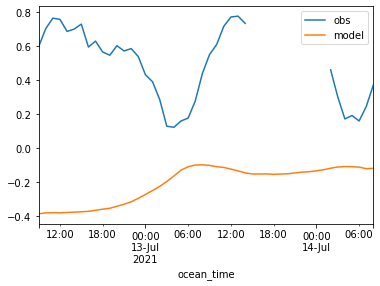

In [17]:
df.plot()

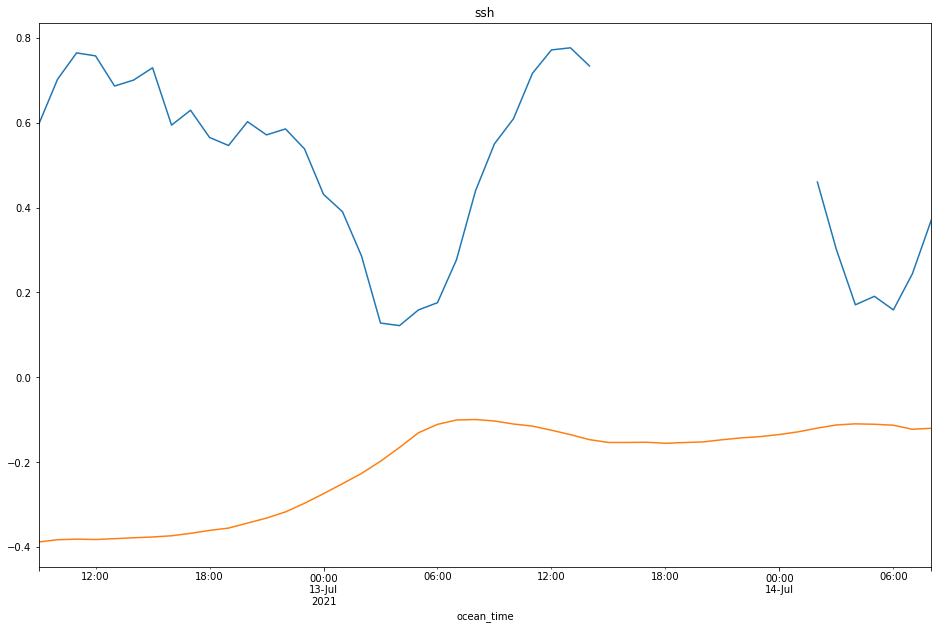

In [18]:
df.omsa.plot('ssh')